In [ ]:
# https://ahnjg.tistory.com/33

In [39]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

In [2]:
plt.style.use('classic')

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
)

In [4]:
csv_path, _ = os.path.splitext(zip_path)

In [12]:
from datetime import datetime

In [16]:
df = pd.read_csv(csv_path)
df['Date Time'] = df['Date Time'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y %H:%M:%S'))
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [17]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

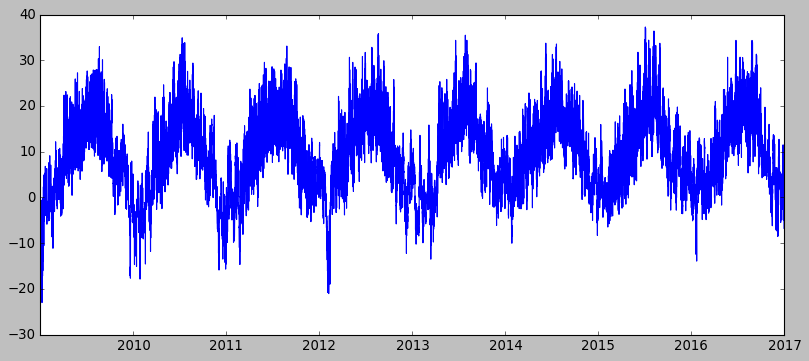

In [18]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
plt.plot(uni_data)
plt.show()

In [21]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

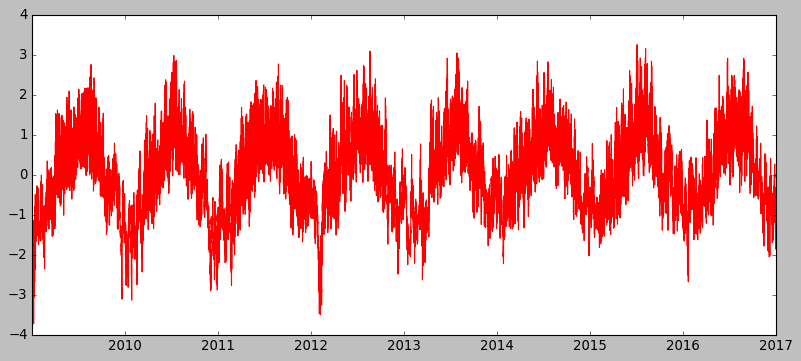

In [27]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
plt.plot(uni_data, color='red')
plt.show()

In [74]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    start_index = 0
    end_index = TRAIN_SPLIT
    history_size = 20
    target_size = 0

    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(uni_data)-target_size

    for i in np.arange(start_index, end_index):
        indices = np.arange(i-history_size, i)
        data.append(np.reshape(np.array(uni_data[indices]), (history_size, 1)))
        labels.append(uni_data[i+target_size])
        
    return np.array(data), np.array(labels)

In [76]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, univariate_past_history, univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None, univariate_past_history, univariate_future_target)

In [131]:
delta = 0
plot_data = [x_train_uni[0], y_train_uni[0], np.mean(x_train_uni[0])]

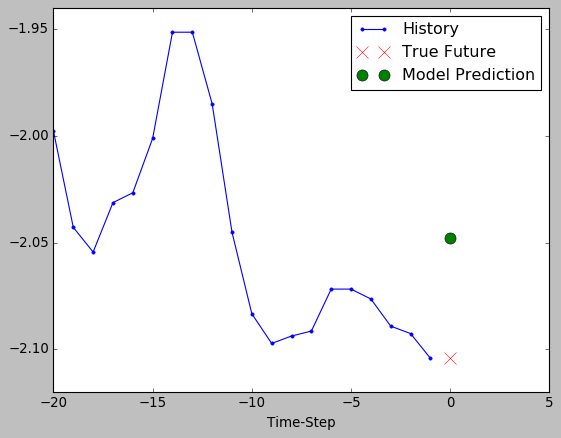

In [132]:
labels = ['History', 'True Future', 'Model Prediction']
marker = ['.-', 'rx', 'go', 'o']
time_steps = list(range(-plot_data[0].shape[0], 0))
future = delta if delta else 0
for i, x in enumerate(plot_data):
    if i:
        plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
    else:
        plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
plt.legend()
plt.xlim([time_steps[0], (future+5)])
plt.xlabel('Time-Step')
plt.show()

In [155]:
x_train_uni.shape

(299980, 20, 1)

In [179]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = train_univariate.batch(BATCH_SIZE).repeat()

In [180]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [181]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

ValueError: Error when checking input: expected lstm_2_input to have 3 dimensions, but got array with shape (256, 256, 20, 1)

In [182]:
EVALUATION_INTERVAL = 200
EPOCHS = 10
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 5s 24ms/step - loss: 0.3923


ValueError: Error when checking input: expected lstm_2_input to have 3 dimensions, but got array with shape (None, None, 20, 1)